<a href="https://colab.research.google.com/github/MilanCugur/PUBLISH_ME/blob/master/ETH_Zurich_Baseline_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
from zipfile import ZipFile

from keras.utils import Sequence
from random import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [3]:
%%time
# Extract images to 'ImageDisk' folder

path = './drive/My Drive/Eth_Zurich_Dataset/ETH_png_archive.zip'  # Different .zip folder with images
archive = ZipFile(path, 'r')
archive.extractall('./ImageDisk')  
archive.close()

CPU times: user 31.9 s, sys: 20.3 s, total: 52.2 s
Wall time: 1min 2s


In [4]:
!ls ImageDisk/ | wc -l

369455


# One Hot Encoding

In [0]:
# OneHot Encoding
class OneHot():  
  # classes = list of classes : 0-9, a-z, A-Z
  # n = number of classes     : 62
  
  def __init__(self, classes):
    self.classes = classes
    self.n = len(classes)
    
  def encode(self, class_name):
    one_hot = np.zeros(shape=(self.n), dtype=np.int8)
    class_index = self.classes.index(class_name)
    one_hot[class_index] = 1
    return one_hot
  
  def encode_all(self, list_class_names):
    return np.array([self.encode(class_name) for class_name in list_class_names])
  
  def decode(self, one_hot):
    class_index = one_hot.argmax()
    return self.classes[class_index]
  
  def decode_all(self, list_one_hots):
    return np.array([self.decode(one_hot) for one_hot in list_one_hots])

In [6]:
alphabet = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'.,-()/") 
alphabet.insert(0, '') # '\x00' character, i.e., ord(0) to label concatenations.
print(alphabet)
print(len(alphabet))

['', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", '.', ',', '-', '(', ')', '/']
70


In [0]:
OH_L = OneHot(sorted(alphabet))

# Model

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam  # First, naive approach
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger  # Add callbacks to model
from keras.models import load_model  # Save model params
from keras.layers import LeakyReLU, concatenate
from keras.layers.advanced_activations import PReLU
from keras.initializers import glorot_normal

import keras.backend as K

In [0]:
BOX_SIZE = 28                          # (28, 28) images; fixed size; I already preprocessed it
image_shape = (BOX_SIZE, BOX_SIZE, 1)  # (28, 28, 1) shape for tensorflow
number_of_classes = len(alphabet)

In [10]:
x_input = Input(shape=image_shape)  # shape=(?, 24, 24, 1)

x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x_input)  # shape=(?, 62, 62, 32)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), padding='same')(x)                                                      # shape=(?, 31, 31, 32)
x = Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x)        # shape=(?, 29, 29, 32)
x = Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), padding='same')(x)                                                      # shape=(?, 15, 15, 32)
x = Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), activation='relu', padding='valid')(x)        # shape=(?, 14, 14, 32)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), padding='same')(x)                                                     # shape=(?, 5, 5, 32); dim: 800; with (2,2) dim is ~1500
x = Flatten()(x)                                                                                       # shape=(?, ?); depends on mini btch size; alternative batch_flatten()

x = Dense(units=768, activation='relu')(x)        # shape=(?, 768) 
x = Dropout(rate=0.25)(x)                          # shape=(?, 768) 
x = Dense(units=256, name='next_to_last')(x)                           # shape=(?, 256)
x = Dropout(rate=0.25)(x)                          # shape=(?, 256)

y_output = Dense(units=number_of_classes, activation='softmax')(x)  # shape=(?, 62)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
recognizer = Model(inputs=x_input, outputs=y_output, name='recognizer')

In [12]:
recognizer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 48)        13872     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 48)          20784     
__________

In [0]:
recognizer.compile(optimizer=Adam(lr=1e-3), loss=categorical_crossentropy, metrics=['accuracy'])   # beta_1=0.9, beta_2=0.999

In [0]:
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', #add min_delta
                           cooldown=1, min_le=1e-8)

estop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')

excel = CSVLogger(filename='./baseline_hacked.csv', separator=',', append=False)

checkp = ModelCheckpoint('./best_w.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

# Data

In [0]:
writers = {}
labels = set()
for image in os.listdir('./ImageDisk/'):
  imageparsed = image.split('_')  # ['trainimage', 'i28871', 'w10174', 'lo', '261-274.png']
  writer = int(imageparsed[2][1:])
  label = imageparsed[3][1:]
  if writer not in writers:
    writers[writer] = 1
  else:
    writers[writer] += 1
    
  labels.add(label)

In [16]:
print(labels)
print(len(labels))

{'', 'X', 'Q', 'J', "'", 'v', 'l', '8', '(', '7', 'D', 'h', 'H', '9', 's', 'Y', 't', 'q', ')', 'e', 'n', 'm', 'b', 'O', 'P', 'r', '1', 'C', 'E', 'F', '.', 'slash', 'u', 'B', '6', '5', 'V', 'S', 'p', ',', 'i', 'W', 'j', 'N', 'M', 'k', 'z', '2', 'a', 'x', 'K', 'U', '0', 'Z', 'g', 'T', '3', 'w', 'f', 'G', 'I', 'y', 'd', 'c', 'L', '-', 'R', 'o', 'A', '4'}
70


In [17]:
print(len(writers.keys()))

294


In [18]:
writers = list(writers.items())
writers = sorted(writers, key=lambda x: x[1])
print(writers)

[(123483, 182), (123521, 384), (123544, 690), (123528, 801), (123519, 808), (123502, 866), (123461, 880), (10023, 898), (123534, 921), (123485, 930), (123459, 947), (123476, 989), (123546, 999), (123460, 1010), (123518, 1024), (123501, 1028), (123515, 1030), (123545, 1037), (123479, 1047), (10094, 1049), (123499, 1053), (10161, 1054), (10088, 1058), (123524, 1062), (10058, 1065), (123478, 1068), (123482, 1073), (123489, 1090), (123539, 1091), (10096, 1092), (10112, 1093), (10104, 1093), (10070, 1097), (123456, 1097), (10214, 1099), (123527, 1103), (123508, 1104), (10095, 1104), (10066, 1106), (10195, 1109), (123488, 1116), (123540, 1123), (10098, 1125), (123532, 1127), (10127, 1132), (10169, 1133), (10177, 1136), (123471, 1137), (123531, 1139), (10163, 1144), (10156, 1145), (123463, 1149), (10061, 1151), (10062, 1156), (10210, 1156), (10153, 1162), (10102, 1163), (10139, 1164), (123510, 1164), (10131, 1164), (10176, 1165), (123512, 1167), (123504, 1168), (10216, 1168), (123503, 1169), 

In [19]:
N = sum([writer[1] for writer in writers])  # No of images
N

369455

In [20]:
testW = []
countImgs = 0
while countImgs<N*0.1:
  testW.append(writers[-1])
  countImgs += writers[-1][1]
  writers = writers[:-1]
  
print(testW) 
print(len(testW))

[(10143, 1654), (10106, 1626), (10018, 1600), (123505, 1594), (10142, 1589), (10015, 1576), (123541, 1564), (10005, 1539), (10019, 1514), (10021, 1498), (10146, 1495), (10103, 1489), (10014, 1483), (10182, 1478), (10004, 1478), (10017, 1477), (10008, 1467), (10044, 1451), (123526, 1446), (10151, 1443), (10135, 1443), (10212, 1442), (10211, 1439), (123486, 1438), (10010, 1435)]
25


In [0]:
# Split and stratify
# 80% : 10% : 10%
# shuffle(writers)
trainW = []
validationW = []

for i in range(0, len(writers)):
  if i%10==5:
    validationW.append(writers[i])
  else:
    trainW.append(writers[i])

trainW = set(trainW)
validationW = set(validationW)
testW = set(testW)

In [0]:
testW = [x[0] for x in testW]
validationW = [x[0] for x in validationW]
trainW = [x[0] for x in trainW]

In [23]:
print(len(trainW))
print(len(validationW))
print(len(testW))

242
27
25


In [24]:
%%time
train_Images = []
train_Labels = []
train_Writers = []

validation_Images = []
validation_Labels = []
validation_Writers = []

test_Images = []
test_Labels = []
test_Writers = []

images = os.listdir('./ImageDisk/')
shuffle(images)
for image in images:
  imageparsed = image.split('_')  # ['trainimage', 'i28871', 'w10174', 'lo', '261-274.png']
  writer = int(imageparsed[2][1:])
  label = imageparsed[3][1:]
  if label=='slash':
    label = '/'
  img = mpimg.imread(os.path.join('./ImageDisk', image))
  if writer in testW:
    test_Images.append(img.reshape(28, 28, 1)/255.0)
    test_Labels.append(OH_L.encode(label))
    test_Writers.append(writer)
  elif writer in validationW:
    validation_Images.append(img.reshape(28, 28, 1)/255.0)
    validation_Labels.append(OH_L.encode(label))
    validation_Writers.append(writer)
  elif writer in trainW:
    train_Images.append(img.reshape(28, 28, 1)/255.0)
    train_Labels.append(OH_L.encode(label))
    train_Writers.append(writer)
  else:
    print('Unrecognized writer, ', writer)  # Throw exception

CPU times: user 27.7 s, sys: 5.82 s, total: 33.6 s
Wall time: 34 s


In [25]:
print(len(train_Writers))
print(len(validation_Writers))
print(len(test_Writers))
print()
print(len(train_Labels))
print(len(validation_Labels))
print(len(test_Labels))
print()
print(len(train_Images))
print(len(validation_Images))
print(len(test_Images))

298313
33484
37658

298313
33484
37658

298313
33484
37658


In [26]:
history = recognizer.fit(x=np.array(train_Images), y=np.array(train_Labels),
                         batch_size=1024, epochs=20, verbose=1, 
                         callbacks=[reduce, estop, excel, checkp], 
                         validation_data=(np.array(validation_Images), np.array(validation_Labels)),          
                         shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 298313 samples, validate on 33484 samples
Epoch 1/20
298313/298313 [==============================] - 17s 56us/step - loss: 1.1445 - acc: 0.6825 - val_loss: 12.9226 - val_acc: 0.0706

Epoch 00001: val_loss improved from inf to 12.92262, saving model to ./best_w.h5
Epoch 2/20
298313/298313 [==============================] - 13s 44us/step - loss: 0.6900 - acc: 0.8013 - val_loss: 12.1508 - val_acc: 0.0910

Epoch 00002: val_loss improved from 12.92262 to 12.15080, saving model to ./best_w.h5
Epoch 3/20
298313/298313 [==============================] - 13s 44us/step - loss: 0.6030 - acc: 0.8249 - val_loss: 8.5250 - val_acc: 0.1164

Epoch 00003: val_loss improved from 12.15080 to 8.52499, saving model to ./best_w.h5
Epoch 4/20
298313/298313 [==============================] - 13s 45us/step - loss: 0.5556 - acc: 0.8374 - val_loss: 2.3659 - val_acc: 0.4456

Epoch 00004: val_loss improved from 8.52499 to 2.36589, saving model to ./best_w.h5

In [0]:
recognizer.load_weights('best_w.h5')

In [28]:
recognizer.evaluate(x=np.array(train_Images), y=np.array(train_Labels), batch_size=256, verbose=1)

298313/298313 [==============================] - 5s 18us/step


[0.3994217890618528, 0.876482084246794]

In [29]:
recognizer.evaluate(x=np.array(validation_Images), y=np.array(validation_Labels), batch_size=256, verbose=1)

33484/33484 [==============================] - 1s 19us/step


[0.5743015290104122, 0.8312029627727758]

In [30]:
recognizer.evaluate(x=np.array(test_Images), y=np.array(test_Labels), batch_size=256, verbose=1)

37658/37658 [==============================] - 1s 18us/step


[0.6479861144587999, 0.8211800945508536]

# Plot

In [0]:
history = recognizer.history

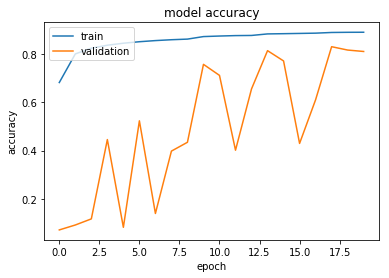

In [44]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

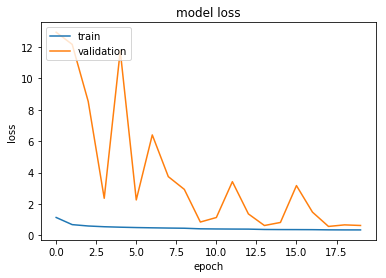

In [45]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Save model

In [0]:
recognizer.save_weights('eth_baseline_weights.h5') 
recognizer.save('eth_baseline_model.h5')

In [0]:
!cp './eth_baseline_weights.h5' './drive/My Drive/Eth_Zurich_weights/eth_baseline_weights.h5'
!cp './eth_baseline_model.h5' './drive/My Drive/Eth_Zurich_weights/eth_baseline_model.h5'

In [34]:
from keras.models import load_model
r = load_model('./drive/My Drive/Eth_Zurich_Dataset/eth_baseline_model.h5')
r.evaluate(x=np.array(test_Images), y=np.array(test_Labels), batch_size=256, verbose=1)

37658/37658 [==============================] - 1s 25us/step


[0.6479861144587999, 0.8211800945508536]

In [0]:
finder = Model(inputs=recognizer.input, outputs=recognizer.get_layer('next_to_last').output)

In [0]:
finder.save_weights('eth_finder_weights.h5') 
finder.save('eth_finder_model.h5')

In [0]:
!cp './eth_finder_weights.h5' './drive/My Drive/Eth_Zurich_weights/eth_finder_weights.h5'
!cp './eth_finder_model.h5' './drive/My Drive/Eth_Zurich_weights/eth_finder_model.h5'